# AiiDA Version 2.0 Archive Demo

::::{grid}
:reverse:

:::{grid-item}
:columns: 12 4 4 4

```{image} ./_static/logo-square.svg
:width: 200px
:class: sd-m-auto
```

:::
:::{grid-item}
:columns: 12 8 8 8
:child-align: center
:class: sd-fs-3 sd-text-center sd-font-weight-bold

AiiDA Version 2.0 Archive Demonstrator
:::
::::

This site is a Jupyter Notebook to demonstrate the new [AiiDA](aiida) v2.0 archive functionality (see [aiidateam/aiida-core#5145](https://github.com/aiidateam/aiida-core/pull/5145)).

The new archive gives **full** access to the AiiDA data exploration API,
without the need to import it into a profile, or even have a profile loaded or PostgreSQL installed.
This allows for post-computation analysis and sharing of data with colleagues,
without the usual setup overhead of AiiDA: simply install `aiida-core` and go!

:::{tip}
The outputs of this notebook are dynamically generated on documentation build.
Use the {octicon}`rocket` dropdown at the top of the page to launch interactive sessions.
:::

In [1]:
from aiida import orm, __version__

__version__

/home/docs/checkouts/readthedocs.org/user_builds/aiida-archive-demo/conda/latest/lib/python3.8/site-packages/aiida/manage/configuration/settings.py:51: UserWarning: Creating AiiDA configuration folder `/home/docs/.aiida`.
  warnings.warn(f'Creating AiiDA configuration folder `{path}`.')


'2.0.0a1'

## Reading the archive version and metadata

After loading the archive format class, we can read the archive version of any legacy archive.

In [2]:
from aiida.tools.archive import get_format

archive_format = get_format()
archive_format.latest_version

'1.0'

In [3]:
archive_format.read_version("archives/calc.aiida")

'1.0'

If the archive is not at the latest version, you will need to run `verdi archive migrate`, which will migrate the archive to the latest version.

Once the archive is at the current version, we can read the metadata of the archive.
To read data from the archive, similar to a file, we must use the `open` context.

In [4]:
import yaml

with archive_format.open("archives/calc.aiida", mode="r") as archive:
    metadata = archive.get_metadata()
print(yaml.dump(metadata))

aiida_version: 2.0.0a1
compression: 6
creation_parameters:
  entities_starting_set:
    node:
    - 05d64c2c-8f49-446f-bd07-8509d55e0c49
  entity_counts:
    computers: 2
    links: 31
    nodes: 32
    users: 2
  graph_traversal_rules:
    call_calc_backward: true
    call_calc_forward: true
    call_work_backward: true
    call_work_forward: true
    create_backward: true
    create_forward: true
    input_calc_backward: true
    input_calc_forward: false
    input_work_backward: true
    input_work_forward: false
    return_backward: false
    return_forward: true
  include_authinfos: false
  include_comments: true
  include_logs: true
ctime: '2021-10-27T09:16:52.242244'
export_version: '1.0'
key_format: sha256



## Querying the archive

We can load any entity (node, computer, user, etc.) from the archive with the `get` method of the read handle.

In [5]:
with archive_format.open("archives/calc.aiida", mode="r") as archive:
    node = archive.get(orm.Node, uuid="05d64c2c-8f49-446f-bd07-8509d55e0c49")
    print(node)
    print(node.exit_status)

uuid: 05d64c2c-8f49-446f-bd07-8509d55e0c49 (pk: 72505) (aiida.calculations:quantumespresso.pw)
0


Note, if you try to access data from the archive outside of the context of the archive, you will get an error (unless it has already been loaded).

In [6]:
node.computer

DetachedInstanceError: Parent instance <DbNode at 0x7fd6adc55100> is not bound to a Session; lazy load operation of attribute 'dbcomputer' cannot proceed (Background on this error at: https://sqlalche.me/e/14/bhk3)

We can access the full `QueryBuilder` interface, to query data in the archive, see [the querying how-to guide](aiida:how-to:data:find).

In [7]:
with archive_format.open("archives/calc.aiida", mode="r") as archive:
    qb = archive.querybuilder()
    qb.append(orm.Node, tag="calc", filters={'uuid': '05d64c2c-8f49-446f-bd07-8509d55e0c49'})
    qb.append(orm.Node, with_incoming="calc")
    print(qb.all())

[[<StructureData: uuid: cc4c6660-b002-456d-bb84-9bf6bf30f04e (pk: 19404)>], [<Dict: uuid: 1dea3c23-5337-4ed6-8090-637653c2fe08 (pk: 19408)>], [<TrajectoryData: uuid: bf67bdd6-e7d2-4e6e-b15d-2ae47abcfb0b (pk: 19432)>], [<Data: uuid: b17bfdf4-e9e3-4e4b-973c-e6456c9c9c9e (pk: 19411)>], [<FolderData: uuid: 1d38f6d9-74ad-4387-9570-4903009fd87b (pk: 19406)>], [<RemoteData: uuid: f5ddc748-f6c5-4b2a-ac19-149f63ea8506 (pk: 73067)>]]


## Visualising the archive provenance

We can use the AiiDA provenance viewer to view the provenance of the archive, see [the tutorial here](aiida:how-to:data:visualise-provenance).
Note, you will need [Graphviz](https://www.graphviz.org/) installed for this feature.

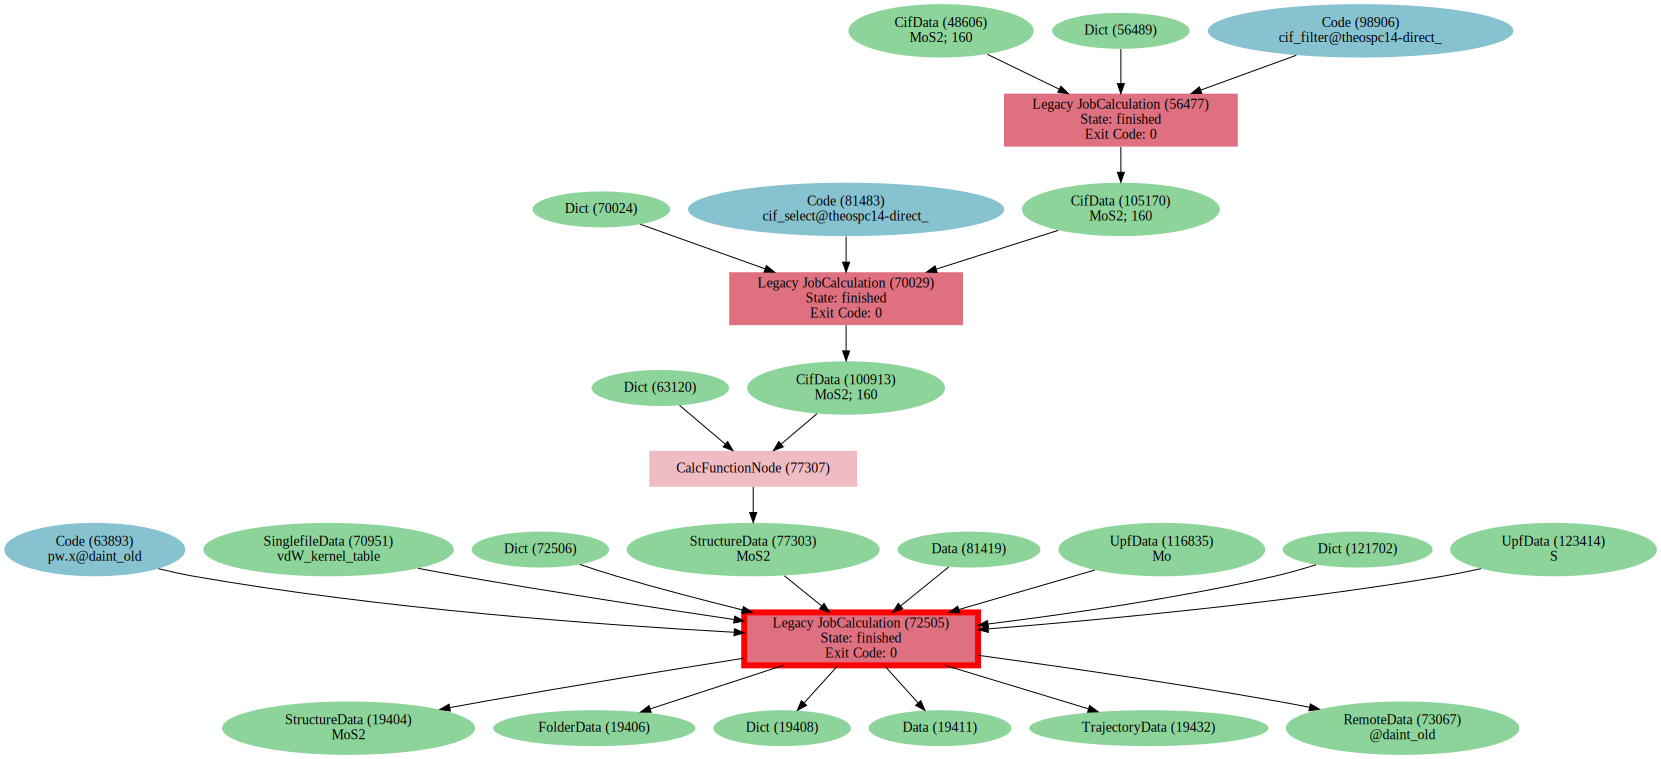

In [8]:
with archive_format.open("archives/calc.aiida", mode="r") as archive:
    graph = archive.graph()
    graph.recurse_descendants("05d64c2c-8f49-446f-bd07-8509d55e0c49")
    graph.recurse_ancestors("05d64c2c-8f49-446f-bd07-8509d55e0c49")
graph.graphviz

## Analysing data from the archive

We can now plot data from the outputs of computations, for example using [matplotlib](https://matplotlib.org/).

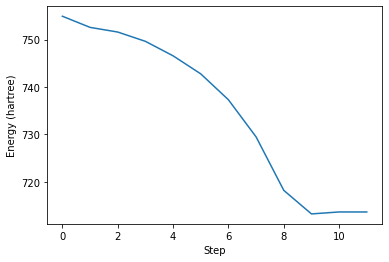

In [9]:
import matplotlib.pyplot as plt

with archive_format.open("archives/calc.aiida", mode="r") as archive:
    traj = archive.get(orm.Node, pk=19432)
    plt.plot(traj.get_array("energy_hartree"))
    ax = plt.gca()
    ax.set_xlabel("Step")
    ax.set_ylabel("Energy (hartree)")

Integration with ASE is also possible, to plot atomic configurations, or even create 3D models (see [ASE viewer for Jupyter notebooks](https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html)).

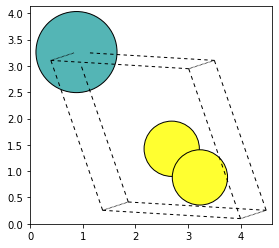

In [10]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms


with archive_format.open("archives/calc.aiida", mode="r") as archive:
    atoms = archive.get(orm.Node, pk=19404).get_ase()

fig, ax = plt.subplots()
ax = plot_atoms(atoms, ax, radii=0.5, rotation=("10x,10y,0z"))

In [11]:
from ase.visualize import view


with archive_format.open("archives/calc.aiida", mode="r") as archive:
    atoms = archive.get(orm.Node, pk=19404).get_ase()

view(atoms, viewer='x3d')

## Accessing repository files

Finally, we can access files in the repository, for example to read the raw computation log files.

In [12]:
with archive_format.open("archives/calc.aiida", mode="r") as archive:
    folder = archive.get(orm.Node, pk=19406)
    print(folder.list_object_names())
    print(folder.get_object_content('aiida.out')[:988])

['_scheduler-stderr.txt', '_scheduler-stdout.txt', 'aiida.out', 'data-file.xml']

     Program PWSCF v.5.2.0 starts on 25Aug2016 at 21:53:49 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Parallel version (MPI), running on    21 processors
     K-points division:     npool     =      21
     Reading input from aiida.in

     Current dimensions of program PWSCF are:
     Max number of different atomic species (ntypx) = 10
     Max number of k-points (npk) =  40000
     Max angular momentum in pseudopotentials (lmaxx) =  3

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation      = VDW-DF2-C09 ( 1  4 16  0 2 0)
     Any further DFT definitio